## Check the metrics for various split of the entire dataset

- For the mnist dataset
- This section is created to check density and coverage for the entire dataset
- The dataset is split based on various ```split_size``` using ```stratify```
- For each split, the density and coverage is computed.

#### Example: 
- for ```split_size``` of 0.4, the ```X_model``` has 42,000 images and ```X_validation``` has 28,000 images
- the tree is trained on the ```X_model```
- the query dataset is ```X_validation```

In [18]:
from torch.utils.data import ConcatDataset
# combine the datasets
dataset = ConcatDataset([train_set, test_set])
X=[]; Y=[];
for i in range(len(dataset)):
    x, y = dataset[i]
    X.append(x.numpy())  #.detach().cpu().numpy())
    Y.append(y)
myranges = np.linspace(0.05, 0.4, 10) 
density_check = []
coverage_check = []
val_length = []
for i in myranges:
        X_model, X_validation, y_model, y_validation = train_test_split(X, Y, test_size=i, random_state=42, stratify=np.array(Y))
        real = np.array(X_model).reshape(len(X_model), -1)
        gen = np.array(X_validation).reshape(len(X_validation), -1)
        den = gem_build_density(real, real.shape[0], gen, 'indexflatl2')
        cov = gem_build_coverage(real, real.shape[0], gen, 'indexflatl2')
        density_check.append(den); coverage_check.append(cov); val_length.append(len(X_validation))
        #print(f"Split size: {i:.2f} | Validation size: {len(X_validation)} | Density: {den:.5f} | Coverage: {cov:.5f}")

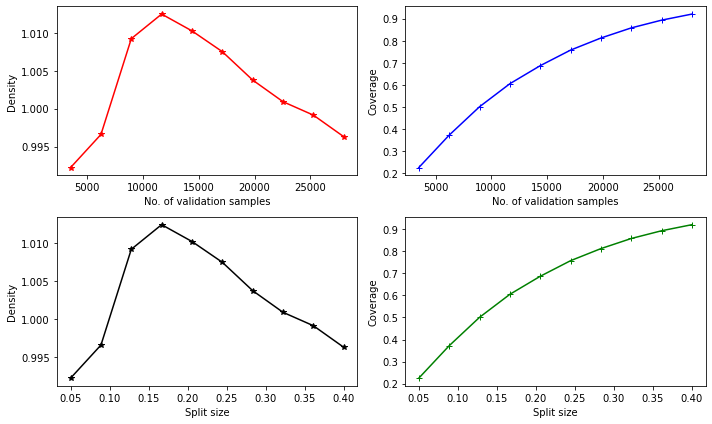

In [39]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
ax[0,0].plot(val_length, density_check, 'r-*')
ax[0,0].set_xlabel("No. of validation samples")
ax[0,0].set_ylabel("Density")


ax[0,1].plot(val_length, coverage_check, 'b-+')
ax[0,1].set_xlabel("No. of validation samples")
ax[0,1].set_ylabel("Coverage")

ax[1,0].plot(myranges, density_check, 'k-*')
ax[1,0].set_xlabel("Split size")
ax[1,0].set_ylabel("Density")


ax[1,1].plot(myranges, coverage_check, 'g-+')
ax[1,1].set_xlabel("Split size")
ax[1,1].set_ylabel("Coverage")
fig.tight_layout()
plt.savefig("Metrics_for_different_splitsizes.png")

-----------------------------------------------------------------------------------------------------------------

## Check the coverage using only 2 classes from the dataset

- Only 2 classes i.e, ```class 0``` and ```class 1``` is considered and coverage is computed for both the cases

- ```coverage00``` -> tree is trained on the entire class 0 and the query dataset is also class 0
- ```coverage005``` -> tree is trained on the entire class 0 and the query dataset is 50% of samples from class 0
- ```coverage01``` -> tree is trained on the entire class 0 and the query dataset is the samples from class 1

- ```classCom``` -> the dataset is formed by combininf class 0 and class 1
- ```coveragecom``` -> tree is trained on the entire classCom and the query dataset is the samples from class 0
- ```coveragecom5``` -> tree is trained on the entire classCom and the query dataset is 10% of samples from class 0

In [6]:
from torch.utils.data import ConcatDataset
# combine the datasets
dataset = ConcatDataset([train_set, test_set])
X=[]; Y=[];
for i in range(len(dataset)):
    x, y = dataset[i]
    X.append(x.numpy())  #.detach().cpu().numpy())
    Y.append(y)

In [21]:
X = torch.from_numpy(np.array(X)).cpu(); Y=torch.from_numpy(np.array(Y)).cpu();
#print(np.unique(Y, return_counts=True)); 
class0 = np.where(Y==0)[0]; class1 = np.where(Y==1)[0]; #print(len(class0), len(class1)); 
newX = X.reshape(X.shape[0], -1); #print(newX.shape)

classCom = torch.from_numpy(np.vstack([newX[class0], newX[class1]])).cpu()

#newX[class0].shape
coverage00 = gem_build_coverage(newX[class0], newX[class0].shape[0], newX[class0], 'indexflatl2')
coverage005 = gem_build_coverage(newX[class0], newX[class0].shape[0], newX[class0][:3452,...], 'indexflatl2')
coverage01 = gem_build_coverage(newX[class0], newX[class0].shape[0], newX[class1], 'indexflatl2')
coveragecom = gem_build_coverage(classCom, classCom.shape[0], newX[class0], 'indexflatl2')
coveragecom5 = gem_build_coverage(classCom, classCom.shape[0], newX[class0][:600,...], 'indexflatl2')
print(f"Coverage: \n Class 0 & Class 0: {coverage00} \n Class 0 & Class 0 (50%): {coverage005} \n" +
      f" Class 0 & Class 1: {coverage01} \n \n Class 0 + Class 1 combined: {coveragecom} \n" +
     f" Class 0 + Class 1 combined(10%): {coveragecom5}")

Coverage: 
 Class 0 & Class 0: 1.0 
 Class 0 & Class 0 (50%): 0.9701579213142395 
 Class 0 & Class 1: 0.0020281036850064993 
 
 Class 0 + Class 1 combined: 0.4673207104206085 
 Class 0 + Class 1 combined(10%): 0.19668470323085785


----------------------------------------------------------------------------------------------------------------------------

# FGSM attack

#### Steps implemented

- #### Attack
    - 20 values of epsilons were considered
    - the model is attacked using the entire validation_set(2100) images -> generates adversarial samples
    - the model is attacked using batches of validation samples(100 images/ batch) -> batch adversarial samples

- #### Metrics
    - ```density``` & ```coverage``` 
    
        -> ```nmodel_vali_density``` --> model_dataset(22000 images stratified split) and validation set **[1 value]**
        
        -> ```bmodel_vali_density``` --> model_dataset(22000 images stratified split) and validation set in batches **[20 values, 1 for batch epsilon]**
        
        -> ```nmodel_vali_adv_density``` --> model_dataset(22000 images stratified split) and validation adversarial samples **[20 values, 1 for each epsilon]**
        
        -> ```bmodel_vali_adv_metrics``` --> model_dataset(22000 images stratified split) and validation batch adversarial samples **[400 values, for each epsilon 20 values]**
     

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
epsilon = np.linspace(0, 1, 20)
from scipy import stats

In [2]:
def all_metrics(path1, path2, path3, colnum, epsilon):
    """
    Funstion to compute and return the stats for the files
    
    Parameters
    ----------------------
    path1: str, the file path to the model_dataset & validation_set
    path2: str, the file path to the model_dataset & validation_set in batches
    path3: str, the file path to the model_dataset & validation adversarial samples in batches
    colnum: int, metrics column to choose in model_dataset & validation adv samples in batches 
            0 - density, 1 - coverage
    epsilon: np. array, the epsilon values
    
    Return
    ----------------------
    nmodel_vali - float, the metric between model_dataset & validation_set
    nmodel_vali_adv - np.array, the metric model_dataset & validation adv samples (len(epsilon), 1)
    bmodel_vali - np.array, the metric between model_dataset & validation set in batches
    q0, q25, q50, q75 - nparray, the 0, 25, 50, 75 quantile for model_dataset 
                & validation samples in batches (metric), size: len(epsilon)
    quantiles - np.array, the 0, 25, 50, 75 quantile for each batch of model_dataset & 
                validation adversarial samples in batches (metric), size: len(epsilon), 4
    quantities - np.array, the mean, median and mode for each batch of model_dataset & 
                validation adversarial samples in batches (metric), size: len(epsilon), 4 
    
    """
    
    # read the model_dataset & validation_set -> metric
    # read the model_dataset & validation adversarial sample -> metric (colnum: 1- density, colnum: 2 - coverage)
    df_nmodel_vali = pd.read_csv(path1, header=None, nrows=4)
    df_nmodel_vali_adv = pd.read_csv(path1, header=None, skiprows=4, sep=" ")
    
    # read the model_dataset & validation_set -> metric in batches
    # read the model_dataset & validation adversarial samples -> metric in batches
    df_bmodel_vali_metrics = pd.read_csv(path2, header=None, skiprows=4, sep=" ")
    df_bmodel_vali_adv_metrics = pd.read_csv(path3, header=None, skiprows=4, sep=" ")
    
    # nmodel_vali -> model_dataset & validation_set -> metric (1 value)
    # nmodel_vali_adv -> model_dataset & validation adversarial sample (length of epsilons)
    nmodel_vali = float((list(df_nmodel_vali.iloc[3].values))[0].split()[-1])
    nmodel_vali_adv = df_nmodel_vali_adv.iloc[:, -1].values
    
    # bmodel_vali -> model_dataset & validation_set -> metric (batch size X 1)
    # bmodel_vali_adv -> model_dataset & validation adversarial samples -> metric in batches (batch_size x len(epsilons))
    # colnum1: 0- density, colnum: 1 - coverage)
    bmodel_vali = df_bmodel_vali_metrics.iloc[:, colnum].values
    bmodel_vali_adv = df_bmodel_vali_adv_metrics.iloc[:, colnum].values
    
    
    quantiles = [] # store quantile info
    quantities= [] # store stats info
    for i in range(len(epsilon)):
        values = bmodel_vali_adv[i:1060:20]
        val,cnt = np.unique(values, return_counts=True)
        idx = np.argmax(cnt)
        qvalues = np.quantile(values, [0, 0.25, 0.5, 0.75])
        quantiles.append(qvalues)
        quantities.append([np.mean(values), np.median(values), val[idx], np.std(values)])
    
    quantiles = np.array(quantiles)
    quantities = np.array(quantities)
    
    q = np.quantile(bmodel_vali, [0, 0.25, 0.5, 0.75])
    q0 = np.repeat(q[0], len(epsilon))
    q25 = np.repeat(q[1], len(epsilon))
    q50 = np.repeat(q[2], len(epsilon))
    q75 = np.repeat(q[3], len(epsilon))
    
    nmodel_vali = np.repeat(nmodel_vali, len(epsilon))
    
    return nmodel_vali, bmodel_vali, nmodel_vali_adv , q0, q25, q50, q75, quantiles, quantities, bmodel_vali_adv    

#### Density

In [4]:
nmodel_vali_den, bmodel_vali_den, nmodel_vali_adv_den, den_q0, den_q25, den_q50, den_q75, den_quantiles, den_quantities = all_metrics('metrics_files/FGSM_attack_density.dat', 'metrics_files/FGSM_attack_batch_metrics.dat',
                                                                                                                 'metrics_files/FGSM_attack_batch_adv_metrics.dat', 0, epsilon)

In [3]:
nmodel_vali_den, bmodel_vali_den, nmodel_vali_adv_den, den_q0, den_q25, den_q50, den_q75, den_quantiles, den_quantities,_ = all_metrics('metrics_files/FGSM_attack_density.dat', 'metrics_files/FGSM_attack_42batch_metrics.dat',
                                                                                                                 'metrics_files/FGSM_attack_42batch_adv_metrics.dat', 0, epsilon)

In [68]:
nmodel_vali_den, bmodel_vali_den, nmodel_vali_adv_den, den_q0, den_q25, den_q50, den_q75, den_quantiles, den_quantities,_= all_metrics('metrics_files/fgsm/pathmnist/FGSM_attack_pathmnist_NewNet_30model_density.dat', 'metrics_files/fgsm/pathmnist/FGSM_attack_pathmnist_100batch_30model_metrics.dat',
                                                                                                                 'metrics_files/fgsm/pathmnist/FGSM_attack_pathmnist_100batch_30model_adv_metrics.dat', 0, epsilon)

In [71]:
nmodel_vali_adv_den.max()

4.5655531883239755

#### Coverage

In [4]:
nmodel_vali_cov, bmodel_vali_cov, nmodel_vali_adv_cov, cov_q0, cov_q25, cov_q50, cov_q75, cov_quantiles, cov_quantities = all_metrics('metrics_files/FGSM_attack_coverage.dat', 'metrics_files/FGSM_attack_batch_metrics.dat',
                                                                                                                 'metrics_files/FGSM_attack_batch_adv_metrics.dat', 1, epsilon)

In [4]:
nmodel_vali_cov, bmodel_vali_cov, nmodel_vali_adv_cov, cov_q0, cov_q25, cov_q50, cov_q75, cov_quantiles, cov_quantities,_ = all_metrics('metrics_files/FGSM_attack_coverage.dat', 'metrics_files/FGSM_attack_42batch_metrics.dat',
                                                                                                                 'metrics_files/FGSM_attack_42batch_adv_metrics.dat', 1, epsilon)

In [72]:
nmodel_vali_cov, bmodel_vali_cov, nmodel_vali_adv_cov, cov_q0, cov_q25, cov_q50, cov_q75, cov_quantiles, cov_quantities,_ = all_metrics('metrics_files/fgsm/pathmnist/FGSM_attack_pathmnist_NewNet_30model_coverage.dat', 'metrics_files/fgsm/pathmnist/FGSM_attack_pathmnist_100batch_30model_metrics.dat',
                                                                                                                 'metrics_files/fgsm/pathmnist/FGSM_attack_pathmnist_100batch_30model_adv_metrics.dat', 1, epsilon)

In [76]:
cov_quantiles

array([[0.00399385, 0.00847874, 0.01152323, 0.0161718 ],
       [0.00667823, 0.0136511 , 0.01790683, 0.02376666],
       [0.00831506, 0.01715389, 0.02154058, 0.0270403 ],
       [0.00910073, 0.01849609, 0.02239173, 0.02903722],
       [0.00985367, 0.01879072, 0.02294824, 0.02890628],
       [0.00857695, 0.0203948 , 0.02376666, 0.02864438],
       [0.00785675, 0.02137689, 0.02504338, 0.0292009 ],
       [0.00752938, 0.02291551, 0.02805513, 0.03358759],
       [0.00625266, 0.0256981 , 0.02943006, 0.03856353],
       [0.00615445, 0.02906996, 0.03502799, 0.04589649],
       [0.0059253 , 0.03276918, 0.04383409, 0.05316398],
       [0.00540151, 0.03496252, 0.05208367, 0.05859823],
       [0.00527057, 0.03637018, 0.05466985, 0.05958032],
       [0.00510688, 0.03538809, 0.05368776, 0.05958032],
       [0.00448489, 0.030183  , 0.05103611, 0.05689593],
       [0.00373195, 0.02487969, 0.04956297, 0.05630668],
       [0.00310996, 0.01872524, 0.04720595, 0.06344322],
       [0.00268439, 0.01885619,

In [27]:
c = np.array(bmodel_vali_cov)
c.mean()

0.013698038170641323

## Plot

- ```model_vali``` --> model_dataset(22000 images stratified split) and validation set **[1 value]**
- ```model_vali_adv``` --> model_dataset(22000 images stratified split) and validation adversarial samples **[20 values, 1 for each epsilon]**

In the coverage plot, the uncertainity band was constructed by
 - for each epsilon, 
     - take ```model_vali +  nmodel_vali_adv_density``` -> forms upper bound
     - take ```model_vali -  nmodel_vali_adv_density``` -> forms lower bound

- P.S: this will be rectifed by the next meeting


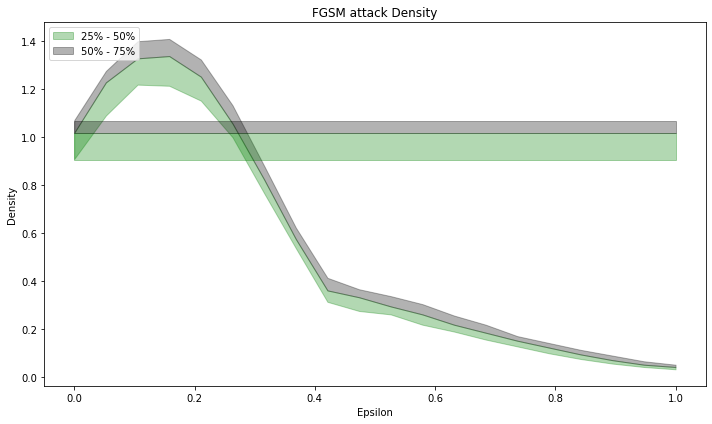

In [5]:
fig,ax = plt.subplots(figsize=(10, 6))
#ax.plot(epsilon, nmodel_vali_adv_den, label='model_vali_adv', lw=4, ls='--')
#ax.fill_between(epsilon, den_quantiles[:,0], den_quantiles[:,1], color='b', alpha=0.3, label='25%')
ax.fill_between(epsilon, den_quantiles[:,1], den_quantiles[:,2], color='g', alpha=0.3, label='25% - 50%')
ax.fill_between(epsilon, den_quantiles[:,2], den_quantiles[:,3], color='k', alpha=0.3, label='50% - 75%')
#ax.plot(epsilon, nmodel_vali_den, ls='--', lw=3, c='r', label='model_vali')
#ax.fill_between(epsilon, den_q0, den_q25, color='b', alpha=0.3)
ax.fill_between(epsilon, den_q25, den_q50, color='g', alpha=0.3)
ax.fill_between(epsilon, den_q50, den_q75, color='k', alpha=0.3)
ax.set_xlabel("Epsilon")
ax.set_ylabel("Density")
ax.set_title("FGSM attack Density")
ax.legend(loc='upper left')
fig.tight_layout()
#plt.savefig("FGSM_attack_pathmnist_density.png")

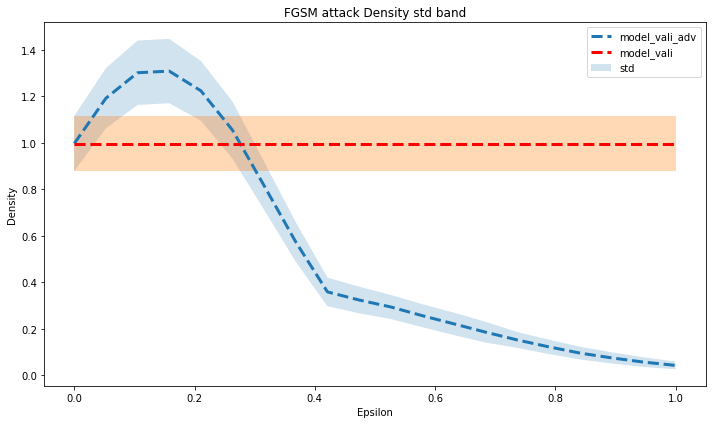

In [20]:
fig,ax = plt.subplots(figsize=(10, 6))
ax.plot(epsilon, nmodel_vali_adv_den, label='model_vali_adv', lw=3, ls='--')
ax.fill_between(epsilon, nmodel_vali_adv_den+den_quantities[:,3], nmodel_vali_adv_den-den_quantities[:,3], alpha=0.2, label='std')
ax.plot(epsilon, nmodel_vali_den, ls='--', lw=3, c='r', label='model_vali')
ax.fill_between(epsilon, nmodel_vali_den+np.std(bmodel_vali_den), nmodel_vali_den-np.std(bmodel_vali_den), alpha=0.3)
ax.set_xlabel("Epsilon")
ax.set_ylabel("Density")
ax.set_title("FGSM attack Density std band")
ax.legend()
fig.tight_layout()
#plt.savefig('FGSM_attack_density_stdband.png')

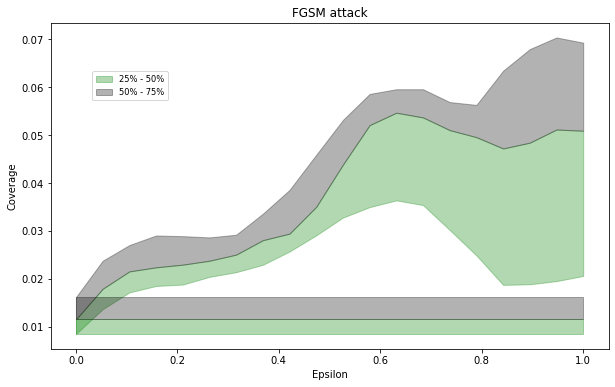

In [29]:
fig,ax = plt.subplots(figsize=(10, 6))
#ax.plot(epsilon, cov_quantities[:,1], label='model_vali_adv_median', lw=3, ls='--')
#ax.plot(epsilon, nmodel_vali_adv_cov, label='model_vali_adv', lw=3, ls='--')
#ax.fill_between(epsilon, nmodel_vali_adv_cov+cov_quantities[:, 3], nmodel_vali_adv_cov-cov_quantities[:, 3], alpha=0.3, label='std')
#ax.fill_between(epsilon, cov_quantiles[:,0], cov_quantiles[:,1], color='b', alpha=0.3, label='25%')
ax.fill_between(epsilon, cov_quantiles[:,1], cov_quantiles[:,2], color='g', alpha=0.3, label='25% - 50%')
ax.fill_between(epsilon, cov_quantiles[:,2], cov_quantiles[:,3], color='k', alpha=0.3, label='50% - 75%')
#ax.plot(epsilon, nmodel_vali_cov, ls='--', lw=3, c='r', label='model_vali')
#ax.fill_between(epsilon, nmodel_vali_cov+np.std(nmodel_vali_cov), nmodel_vali_cov-np.std(nmodel_vali_cov), alpha=0.2)
#ax.fill_between(epsilon, cov_q0, cov_q25, color='b', alpha=0.3)
#ax.plot(epsilon, np.repeat(np.median(c), 20), label='model_vali_median', lw=3, ls='--')
ax.fill_between(epsilon, cov_q25, cov_q50, color='g', alpha=0.3)
ax.fill_between(epsilon, cov_q50, cov_q75, color='k', alpha=0.3)
ax.set_xlabel("Epsilon")
ax.set_ylabel("Coverage")
ax.set_title("FGSM attack")
#ax.legend()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.15, 0.74), fontsize='small')
#plt.savefig("FGSM_coverage_bands.png")
#plt.show()
plt.savefig('./plots/FGSM_attack/FGSM_attack_pathmnist_coverage.png')

In [132]:
normal_den = pd.read_csv('metrics_files/FGSM_attack_density.dat', header=None, skiprows=4, sep=" ")
overfit_den = pd.read_csv('metrics_files/fgsm/model_capacity/FGSM_attack_overfit_density.dat', header=None, skiprows=4, sep=" ")
underfit_den = pd.read_csv('metrics_files/fgsm/model_capacity/FGSM_attack_underfit_density.dat', header=None, skiprows=4, sep=" ")

normal_cov = pd.read_csv('metrics_files/FGSM_attack_coverage.dat', header=None, skiprows=4, sep=" ")
overfit_cov = pd.read_csv('metrics_files/fgsm/model_capacity/FGSM_attack_overfit_coverage.dat', header=None, skiprows=4, sep=" ")
underfit_cov = pd.read_csv('metrics_files/fgsm/model_capacity/FGSM_attack_underfit_coverage.dat', header=None, skiprows=4, sep=" ")

In [133]:
normal_den_res = pd.read_csv('metrics_files/fgsm/resnet/FGSM_attack_resnet18_density.dat', header=None, skiprows=4, sep=" ")
overfit_den_res = pd.read_csv('metrics_files/fgsm/resnet/FGSM_attack_resnet34_density.dat', header=None, skiprows=4, sep=" ")
underfit_den_res = pd.read_csv('metrics_files/fgsm/resnet/FGSM_attack_resnet50_density.dat', header=None, skiprows=4, sep=" ")

normal_cov_res = pd.read_csv('metrics_files/fgsm/resnet/FGSM_attack_resnet18_coverage.dat', header=None, skiprows=4, sep=" ")
overfit_cov_res = pd.read_csv('metrics_files/fgsm/resnet/FGSM_attack_resnet34_coverage.dat', header=None, skiprows=4, sep=" ")
underfit_cov_res = pd.read_csv('metrics_files/fgsm/resnet/FGSM_attack_resnet50_coverage.dat', header=None, skiprows=4, sep=" ")

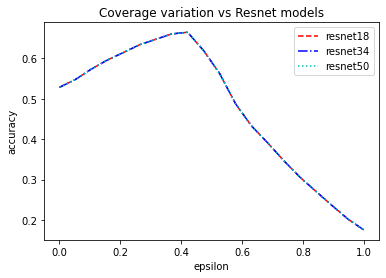

In [145]:
plt.plot(epsilon, normal_den_res.iloc[:, 1], c='r', ls='--', label='resnet18')
plt.plot(epsilon, overfit_den_res.iloc[:, 1], c='b', ls='-.', label='resnet34')
plt.plot(epsilon, underfit_den_res.iloc[:, 1], c='c', ls=':',label='resnet50')
#plt.plot(epsilon, np.repeat(normal_den.iloc[:, -1][0], len(epsilon)), c='k', label='model_vali')
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.title('Coverage variation vs Resnet models')
plt.legend()
plt.savefig('FGSM_attack_resnetmodels_accuracy.png')

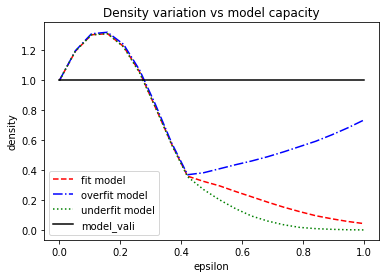

In [26]:
plt.plot(epsilon, normal_den.iloc[:, -1], c='r', ls='--', label='fit model')
plt.plot(epsilon, overfit_den.iloc[:, -1], c='b', ls='-.', label='overfit model')
plt.plot(epsilon, underfit_den.iloc[:, -1], c='g', ls=':',label='underfit model')
plt.plot(epsilon, np.repeat(normal_den.iloc[:, -1][0], len(epsilon)), c='k', label='model_vali')
plt.xlabel('epsilon')
plt.ylabel('density')
plt.title('Density variation vs model capacity')
plt.legend()
#plt.savefig('FGSM_attack_modelcapacity_density.png')

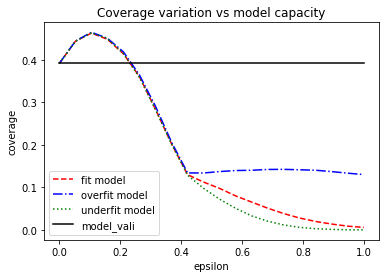

In [27]:
plt.plot(epsilon, normal_cov.iloc[:, -1], c='r', ls='--', label='fit model')
plt.plot(epsilon, overfit_cov.iloc[:, -1], c='b', ls='-.', label='overfit model')
plt.plot(epsilon, underfit_cov.iloc[:, -1], c='g', ls=':',label='underfit model')
plt.plot(epsilon, np.repeat(normal_cov.iloc[:, -1][0], len(epsilon)), c='k', label='model_vali')
plt.xlabel('epsilon')
plt.ylabel('coverage')
plt.title('Coverage variation vs model capacity')
plt.legend()
plt.savefig('FGSM_attack_modelcapacity_coverage.png')

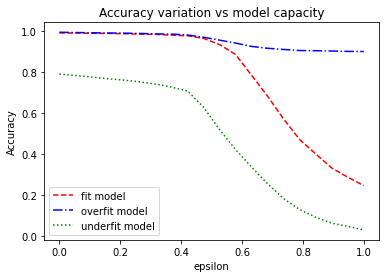

In [29]:
plt.plot(epsilon, normal_cov.iloc[:, 1], c='r', ls='--', label='fit model')
plt.plot(epsilon, overfit_cov.iloc[:, 1], c='b', ls='-.', label='overfit model')
plt.plot(epsilon, underfit_cov.iloc[:, 1], c='g', ls=':',label='underfit model')
#plt.plot(epsilon, np.repeat(normal_cov.iloc[:, -1][0], len(epsilon)), c='k', label='model_vali')
plt.xlabel('epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy variation vs model capacity')
plt.legend()
plt.savefig('FGSM_attack_modelcapacity_accuracy.png')

No handles with labels found to put in legend.


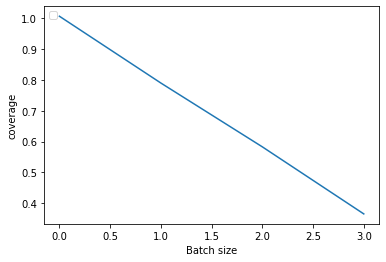

In [41]:
density = [1.0072, 0.7902, 0.5829, 0.3650]
myticks = ['full batch', '25%', '50%', '75%']
plt.plot(range(len(density)),density)
#plt.xticks(range(len(density)), myticks)
plt.xlabel('Batch size')
plt.ylabel('coverage')
plt.legend(loc='upper left')

-------------------------------------------------------------------------------------------------------------------------------

# Boundary Attack

### Attack the model using validation_dataset

- the Boundary Attack cannot be implemented if the starting images are not adversaries
- to create these adversarial samples, ```init_attack``` needs to be specified
- any of the attacks inherited from ```Minimization Attack``` can be used for this purpose
- all the initial samples should be strictly adversarial samples

##### Two different attacks were experimented
- ```SaltandPepper```, ```LinearSearchBlendedUniformNoiseAttack```
- modify the hyperparameters within these attacks to generate the adversarial samples
- the generated samples are given as the starting points for the ```BoundaryAttack```
- time complexity increases with changing these hyperparameters

--------------------------------------------------------------------------------------------------------------------------

The steps implemedted for the FGSM attack remains the same, however, 2 points were changed

- the ```epsilon``` value is nullified i.e., **None** was specified.
- the model_dataset has 67000 images for the computation of metrics

The uncertainity band is implemented the same way as stated for FGSM attack


In [4]:
df_bdy_attack_basic = pd.read_csv('metrics_files/Boundary_attack_metrics.dat', header=None, nrows=5)
df_bdy_attack_all = pd.read_csv('metrics_files/Boundary_attack_metrics.dat', header=None, sep=" ", skiprows=5)
df_bdy_coverage_basic = pd.read_csv('metrics_files/Boundary_attack_coverage.dat', header=None, nrows=4)

In [6]:
df_bdy_attack_header = pd.read_csv('metrics_files/bdy_attack/Boundary_attack_21batch_metrics.dat', header=None, nrows=7)
df_bdy_attack_data = pd.read_csv('metrics_files/bdy_attack/Boundary_attack_21batch_metrics.dat', header=None, sep=" ", skiprows=7)

In [4]:
#prefix = [21, 42, 60, 84, 120, 140] # pathmnist
#prefix= [53, 100, 150, 200, 250, 300]
prefix= [49, 100, 150, 200, 250, 300] #organmnist
bmodel_validation_den_q = [];bmodel_validation_adv_den_q=[];bmodel_validation_cov_q=[];bmodel_validation_adv_cov_q=[];
bmodel_validation_den_s=[];bmodel_validation_adv_den_s=[];bmodel_validation_cov_s=[];bmodel_validation_adv_cov_s=[];
for i in prefix:
    df_bdy_attack_data = pd.read_csv(('metrics_files/bdy_attack/Boundary_attack_organmnist_'+str(i)+'batch_metrics.dat'), header=None, sep=" ", skiprows=7)
    bmodel_validation_den = df_bdy_attack_data.iloc[:,1].values
    bmodel_validation_adv_den = df_bdy_attack_data.iloc[:,2].values
    bmodel_validation_cov = df_bdy_attack_data.iloc[:,3].values
    bmodel_validation_adv_cov = df_bdy_attack_data.iloc[:,4].values
    
    # quantile info
    bmodel_validation_den_q.append(compute_quantiles(bmodel_validation_den))
    bmodel_validation_adv_den_q.append(compute_quantiles(bmodel_validation_adv_den))
    bmodel_validation_cov_q.append(compute_quantiles(bmodel_validation_cov))
    bmodel_validation_adv_cov_q.append(compute_quantiles(bmodel_validation_adv_cov))

    # stats info
    bmodel_validation_den_s.append(compute_stats(bmodel_validation_den))
    bmodel_validation_adv_den_s.append(compute_stats(bmodel_validation_adv_den))
    bmodel_validation_cov_s.append(compute_stats(bmodel_validation_cov))
    bmodel_validation_adv_cov_s.append(compute_stats(bmodel_validation_adv_cov))

In [6]:
bmodel_validation_den_q = np.array(bmodel_validation_den_q)
bmodel_validation_adv_den_q = np.array(bmodel_validation_adv_den_q)
bmodel_validation_cov_q = np.array(bmodel_validation_cov_q)
bmodel_validation_adv_cov_q = np.array(bmodel_validation_adv_cov_q)

In [17]:
bmodel_validation_cov_s = np.array(bmodel_validation_cov_s)
bmodel_validation_adv_cov_s = np.array(bmodel_validation_adv_cov_s)
bmodel_validation_den_s = np.array(bmodel_validation_den_s)
bmodel_validation_adv_den_s = np.array(bmodel_validation_adv_den_s)

#xx = np.insert(bmodel_validation_den_s, 4, np.repeat(den_quan_s[1], 4), axis=0)
#yy = np.insert(bmodel_validation_adv_cov_s, 4, np.repeat(cov_adv_quan_s[1], 4), axis=0)
xx = bmodel_validation_cov_s
yy = bmodel_validation_adv_cov_s

In [18]:
x = bmodel_validation_cov_q
y = bmodel_validation_adv_cov_q
print(x.max(), x.min())
print(y.max(), y.min())

0.028619187 0.0039525693
0.035508475 0.0060950833999999995


In [7]:
add_file = pd.read_csv('metrics_files/bdy_attack/Boundary_attack_metrics.dat', header=None, sep=" ", skiprows=5)
den_quan = compute_quantiles(add_file.iloc[:,1].values)
den_adv_quan = compute_quantiles(add_file.iloc[:,2].values)
cov_quan = compute_quantiles(add_file.iloc[:,3].values)
cov_adv_quan = compute_quantiles(add_file.iloc[:,4].values)

In [8]:
den_quan_s = compute_stats(add_file.iloc[:,1].values)
den_adv_quan_s = compute_stats(add_file.iloc[:,2].values)
cov_quan_s = compute_stats(add_file.iloc[:,3].values)
cov_adv_quan_s = compute_stats(add_file.iloc[:,4].values)

In [14]:
cov_quan_s

(0.007377761460000002,
 0.00713549345,
 0.0068630340000000005,
 0.0005827059977325437)

In [47]:
bmodel_validation_adv_cov_q = np.array(bmodel_validation_adv_cov_q)
bmodel_validation_adv_cov_q

array([[2.94550810e-05, 1.47275410e-04, 2.20913100e-04, 2.94550820e-04],
       [1.17820324e-04, 2.94550820e-04, 3.75552270e-04, 4.56553770e-04],
       [3.09278340e-04, 4.19734905e-04, 4.71281300e-04, 5.44919000e-04],
       [3.68188500e-04, 5.30191460e-04, 6.18556700e-04, 6.92194400e-04],
       [6.18556700e-04, 7.95287200e-04, 8.10014700e-04, 9.13107530e-04],
       [6.48011800e-04, 8.54197370e-04, 9.57290100e-04, 1.03829160e-03]])

In [48]:
x = np.insert(bmodel_validation_cov_q, 4, np.array(cov_quan), axis=0)
#xxy = np.insert(xx, 4, np.repeat(den_quan_s, 4), axis=0)
print(x.max(), x.min())
y = np.insert(bmodel_validation_adv_cov_q, 4, np.array(cov_adv_quan), axis=0)
#yyx = np.insert(y, 4, np.repeat(den_adv_quan_s, 4), axis=0)
y.max(), y.min()

0.010699558500000001 0.00097201765


(0.0010382916, 2.9455081e-05)

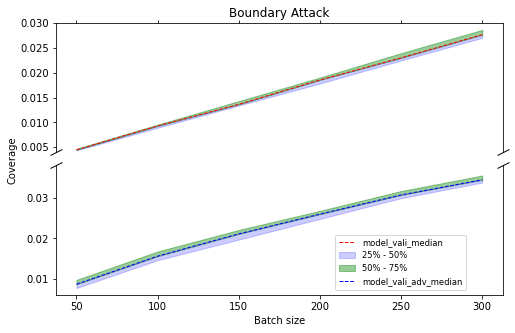

In [27]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,5))
fig.subplots_adjust(hspace=0.1)  # adjust space between axes
#myticks=['20','40','60','80','100','120','140']
myticks=['50','100','150','200','250','300']
# plot the same data on both axes
#ax[0].plot(range(len(prefix)+1), np.repeat(1.0072381, 7), c='r', ls='--', lw=3, label='model_vali')
ax[0].plot(range(len(prefix)), xx[:, 1], c='r', ls='--', lw=1, label='model_vali_median')
ax[0].fill_between(range(len(prefix)), x[:, 1], x[:, 2], color='b', alpha=0.2, label='25% - 50%')
ax[0].fill_between(range(len(prefix)), x[:, 2], x[:, 3], color='g', alpha=0.4, label='50% - 75%')
#ax[0].fill_between(range(len(prefix)), bmxodel_validation_den_q[2], bmodel_validation_den_q[3], color='k', alpha=0.6, label='75%')
#ax1.legend()
#ax[1].plot(range(len(prefix)+1), np.repeat(0.15571429, 7), c='b', ls='--', lw=3, label='model_vali_adv')
ax[1].plot(range(len(prefix)), yy[:, 1], c='b', ls='--', lw=1, label='model_vali_adv_median')
ax[1].fill_between(range(len(prefix)), y[:, 1], y[:, 2], color='b' , alpha=0.2 )#, label='25% - 50%')
ax[1].fill_between(range(len(prefix)), y[:, 2], y[:, 3], color='g', alpha=0.4 )#, label='50% - 75%')
#ax[1].fill_between(range(len(bmodel_validation_den)), bmodel_validation_adv_den_q[2], bmodel_validation_adv_den_q[3], color='k', alpha=0.6)
#ax[1].legend()
#ax[0].set_ylabel("Density")
ax[0].set_title("Boundary Attack")

# zoom-in / limit the view to different portions of the data 
ax[0].set_ylim(0.0039525693, 0.03)  # outliers only
ax[1].set_ylim(0.0060950833999999995, 0.038)  # most of the data
#ax2.set_yticks(np.arange(0.002, 0.008, 0.002))

# hide the spines between ax and ax2
ax[0].spines['bottom'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].xaxis.tick_top()
ax[0].tick_params(labeltop=False) # don't put tick labels at the top
ax[1].set_xticks(range(len(prefix)))
ax[1].set_xticklabels(myticks)
ax[1].set_xlabel('Batch size')
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)
handles, labels = [(a + b) for a, b in zip(ax[0].get_legend_handles_labels(), ax[1].get_legend_handles_labels())]
fig.legend(handles, labels, loc=(0.65, 0.13), fontsize='small')
fig.text(0.04, 0.5, 'Coverage', va='center', rotation='vertical')
plt.savefig('Boundary_attack_organmnist_cov_quantiles_median.png')

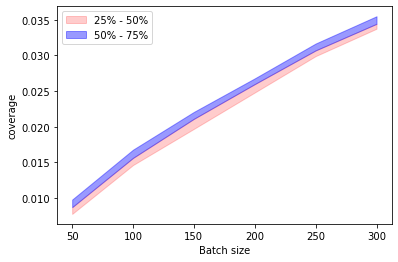

In [32]:
plt.fill_between(range(len(prefix)), y[:, 1], y[:, 2], color='r', alpha=0.2, label='25% - 50%')
plt.fill_between(range(len(prefix)), y[:, 2], y[:, 3], color='b', alpha=0.4, label='50% - 75%')
#plt.xticks(range(len(prefix)), ['20','40','60','80','100','120','140'])
plt.xticks(range(len(prefix)), myticks)
plt.xlabel('Batch size')
plt.ylabel('coverage')
plt.legend(loc='upper left')
plt.savefig('Boundary_attack_organmnist_cov_a4attk_batchsize.png')

**model_validation_den, model_validation_cov** ==> read the model_dataset & validation_set -> metric (1 value)

**model_validation_adv_den, model_validation_adv_cov** ==> read the model_dataset & validation adv samples -> metric ( 1 value)

In [91]:
model_validation_den = np.repeat(np.array(float((list(df_bdy_attack_basic.iloc[2].values))[0].split()[-1])), 20)
model_validation_adv_den = np.repeat(np.array(float((list(df_bdy_attack_basic.iloc[3].values))[0].split()[-1])), 20)
model_validation_cov = np.repeat(np.array(float((list(df_bdy_coverage_basic.iloc[2].values))[0].split()[-1])), 20)
model_validation_adv_cov = np.repeat(np.array(float((list(df_bdy_coverage_basic.iloc[3].values))[0].split()[-1])), 20)

print(f"Model_val density: {model_validation_den[0]} \nModel_ adv_val density: {model_validation_adv_den[0]}")
print(f"Model_val coverage: {model_validation_cov[0]} \nModel_ adv_val coverage: {model_validation_adv_cov[0]}")

Model_val density: 1.0072381 
Model_ adv_val density: 0.15571429
Model_val coverage: 0.14238586 
Model_ adv_val coverage: 0.0047275405


**bmodel_validation_den, bmodel_validation_cov** ==> read the model_dataset & validation_set -> metric in batches(20 values)

**bmodel_validation_adv_den, bmodel_validation_adv_cov** ==> read the model_dataset & validation adv samples -> metric in batches(20 values)

In [90]:
bmodel_validation_den = df_bdy_attack_all.iloc[:,1].values
bmodel_validation_adv_den = df_bdy_attack_all.iloc[:,2].values
bmodel_validation_cov = df_bdy_attack_all.iloc[:,3].values
bmodel_validation_adv_cov = df_bdy_attack_all.iloc[:,4].values

In [3]:
def compute_quantiles(x):
    return np.quantile(x, [0, 0.25, 0.5, 0.75])

def compute_stats(x):
    val,cnt = np.unique(x, return_counts=True)
    idx = np.argmax(cnt)
    return np.mean(x), np.median(x), val[idx], np.std(x)

In [ ]:
# quantile info
bmodel_validation_den_q = compute_quantiles(bmodel_validation_den)
bmodel_validation_adv_den_q = compute_quantiles(bmodel_validation_adv_den)
bmodel_validation_cov_q = compute_quantiles(model_validation_cov)
bmodel_validation_adv_cov_q = compute_quantiles(model_validation_adv_cov)

# stats info
bmodel_validation_den_s = compute_stats(bmodel_validation_den)
bmodel_validation_adv_den_s = compute_stats(bmodel_validation_adv_den)
bmodel_validation_cov_s = compute_stats(model_validation_cov)
bmodel_validation_adv_cov_s = compute_stats(model_validation_adv_cov)

## Density

In [114]:

print(f"Model vali in batches:     mean: {bmodel_validation_den_s[0]:.5f}, median: {bmodel_validation_den_s[1]:.5f}, mode: {bmodel_validation_den_s[2]:.5f}, std: {bmodel_validation_den_s[3]:.5f}")
print(f"Model adv vali in batches: mean: {bmodel_validation_adv_den_s[0]:.5f}, median: {bmodel_validation_adv_den_s[1]:.5f}, mode: {bmodel_validation_adv_den_s[2]:.5f}, std: {bmodel_validation_adv_den_s[3]:.5f}")

Model vali in batches:     mean: 1.00680, median: 0.97700, mode: 0.93200, std: 0.07948
Model adv vali in batches: mean: 0.17260, median: 0.16900, mode: 0.17200, std: 0.03516


## Coverage

In [118]:
print(f"Model vali in batches:     mean: {bmodel_validation_cov_s[0]:.5f}, median: {bmodel_validation_cov_s[1]:.5f}, mode: {bmodel_validation_cov_s[2]:.5f}, std: {bmodel_validation_cov_s[3]:.5f}")
print(f"Model adv vali in batches: mean: {bmodel_validation_adv_cov_s[0]:.5f}, median: {bmodel_validation_adv_cov_s[1]:.5f}, mode: {bmodel_validation_cov_s[2]:.5f}, std: {bmodel_validation_adv_cov_s[3]:.5f}")

Model vali in batches:     mean: 0.14239, median: 0.14239, mode: 0.14239, std: 0.00000
Model adv vali in batches: mean: 0.00473, median: 0.00473, mode: 0.14239, std: 0.00000


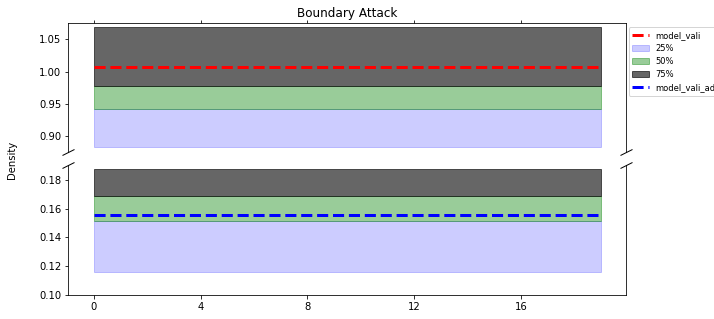

In [78]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.subplots_adjust(hspace=0.1)  # adjust space between axes

# plot the same data on both axes
ax[0].plot(range(len(bmodel_validation_den)), model_validation_den, c='r', ls='--', lw=3, label='model_vali')
ax[0].fill_between(range(len(bmodel_validation_den)), bmodel_validation_den_q[0], bmodel_validation_den_q[1], color='b', alpha=0.2, label='25%')
ax[0].fill_between(range(len(bmodel_validation_den)), bmodel_validation_den_q[1], bmodel_validation_den_q[2], color='g', alpha=0.4, label='50%')
ax[0].fill_between(range(len(bmodel_validation_den)), bmodel_validation_den_q[2], bmodel_validation_den_q[3], color='k', alpha=0.6, label='75%')
#ax1.legend()
ax[1].plot(range(len(bmodel_validation_den)), model_validation_adv_den, c='b', ls='--', lw=3, label='model_vali_adv')
ax[1].fill_between(range(len(bmodel_validation_den)), bmodel_validation_adv_den_q[0], bmodel_validation_adv_den_q[1], color='b', alpha=0.2)
ax[1].fill_between(range(len(bmodel_validation_den)), bmodel_validation_adv_den_q[1], bmodel_validation_adv_den_q[2], color='g', alpha=0.4)
ax[1].fill_between(range(len(bmodel_validation_den)), bmodel_validation_adv_den_q[2], bmodel_validation_adv_den_q[3], color='k', alpha=0.6)
#ax[1].legend()
#ax[0].set_ylabel("Density")
ax[0].set_title("Boundary Attack")

# zoom-in / limit the view to different portions of the data
ax[0].set_ylim(.875, 1.075)  # outliers only
ax[1].set_ylim(0.1, 0.19)  # most of the data
#ax2.set_yticks(np.arange(0.002, 0.008, 0.002))

# hide the spines between ax and ax2
ax[0].spines['bottom'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].xaxis.tick_top()
ax[0].tick_params(labeltop=False) # don't put tick labels at the top
ax[1].set_xticks(range(0,21,4))
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)
handles, labels = [(a + b) for a, b in zip(ax[0].get_legend_handles_labels(), ax[1].get_legend_handles_labels())]
fig.legend(handles, labels, loc=(0.88, 0.7), fontsize='small')
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical')
plt.savefig('Boundary_attack_density_quantiles.png')

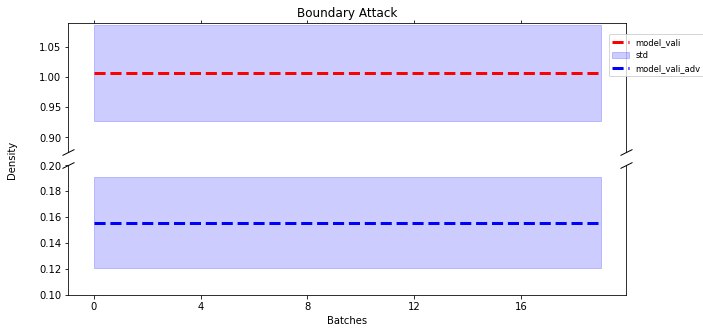

In [88]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.subplots_adjust(hspace=0.1)  # adjust space between axes

# plot the same data on both axes
ax[0].plot(range(len(bmodel_validation_den)), model_validation_den, c='r', ls='--', lw=3, label='model_vali')
ax[0].fill_between(range(len(bmodel_validation_den)), model_validation_den+bmodel_validation_den_s[-1], model_validation_den-bmodel_validation_den_s[-1], color='b', alpha=0.2, label='std')

ax[1].plot(range(len(bmodel_validation_den)), model_validation_adv_den, c='b', ls='--', lw=3, label='model_vali_adv')
ax[1].fill_between(range(len(bmodel_validation_den)), model_validation_adv_den+bmodel_validation_adv_den_s[-1], model_validation_adv_den-bmodel_validation_adv_den_s[-1], color='b', alpha=0.2)

#ax[0].set_ylabel("Density")
ax[0].set_title("Boundary Attack")
ax[1].set_xlabel('Batches')
# zoom-in / limit the view to different portions of the data
ax[0].set_ylim(.875, 1.09)  # outliers only
ax[1].set_ylim(0.1, 0.2)  # most of the data
#ax2.set_yticks(np.arange(0.002, 0.008, 0.002))

# hide the spines between ax and ax2
ax[0].spines['bottom'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].xaxis.tick_top()
ax[0].tick_params(labeltop=False) # don't put tick labels at the top
ax[1].set_xticks(range(0,21,4))
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)
handles, labels = [(a + b) for a, b in zip(ax[0].get_legend_handles_labels(), ax[1].get_legend_handles_labels())]
fig.legend(handles, labels, loc=(0.865, 0.77), fontsize='small')
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical')
plt.savefig('Boundary_attack_density_std.png')

Text(0.04, 0.5, 'Coverage')

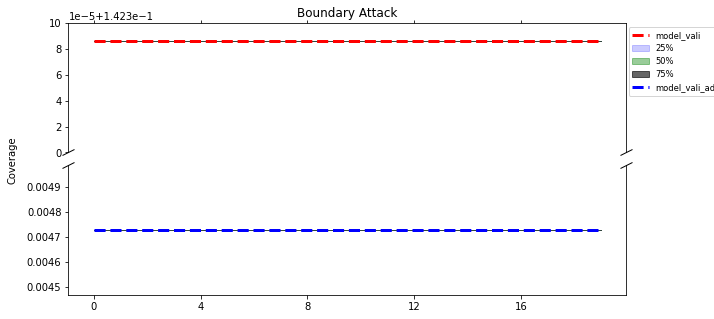

In [109]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.subplots_adjust(hspace=0.1)  # adjust space between axes

# plot the same data on both axes
ax[0].plot(range(len(bmodel_validation_cov)), model_validation_cov, c='r', ls='--', lw=3, label='model_vali')
ax[0].fill_between(range(len(bmodel_validation_cov)), bmodel_validation_cov_q[0], bmodel_validation_cov_q[1], color='b', alpha=0.2, label='25%')
ax[0].fill_between(range(len(bmodel_validation_cov)), bmodel_validation_cov_q[1], bmodel_validation_cov_q[2], color='g', alpha=0.4, label='50%')
ax[0].fill_between(range(len(bmodel_validation_cov)), bmodel_validation_cov_q[2], bmodel_validation_cov_q[3], color='k', alpha=0.6, label='75%')
#ax1.legend()
ax[1].plot(range(len(bmodel_validation_cov)), model_validation_adv_cov, c='b', ls='--', lw=3, label='model_vali_adv')
ax[1].fill_between(range(len(bmodel_validation_cov)), model_validation_adv_cov_q[0], model_validation_adv_cov_q[1], color='b', alpha=0.2)
ax[1].fill_between(range(len(bmodel_validation_cov)), model_validation_adv_cov_q[1], model_validation_adv_cov_q[2], color='g', alpha=0.4)
ax[1].fill_between(range(len(bmodel_validation_cov)), model_validation_adv_cov_q[2], model_validation_adv_cov_q[3], color='k', alpha=0.6)
#ax[1].legend()
#ax[0].set_ylabel("Density")
ax[0].set_title("Boundary Attack")

# zoom-in / limit the view to different portions of the data
ax[0].set_ylim(0.1423, 0.1424)  # outliers only
#ax[1].set_ylim(0.1, 0.19)  # most of the data
#ax2.set_yticks(np.arange(0.002, 0.008, 0.002))

# hide the spines between ax and ax2
ax[0].spines['bottom'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].xaxis.tick_top()
ax[0].tick_params(labeltop=False) # don't put tick labels at the top
ax[1].set_xticks(range(0,21,4))
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)
handles, labels = [(a + b) for a, b in zip(ax[0].get_legend_handles_labels(), ax[1].get_legend_handles_labels())]
fig.legend(handles, labels, loc=(0.88, 0.7), fontsize='small')
fig.text(0.04, 0.5, 'Coverage', va='center', rotation='vertical')
#plt.savefig('Boundary_attack_density_quantiles.png')

Text(0.04, 0.5, 'Coverage')

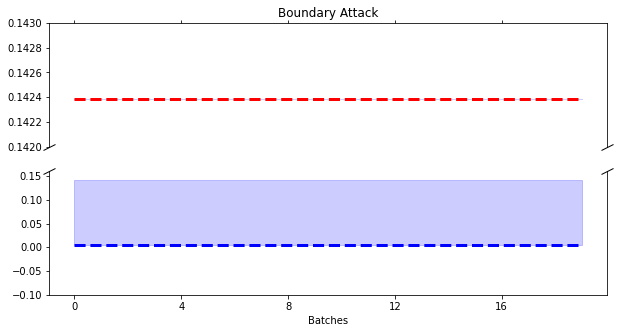

In [112]:
ig, ax = plt.subplots(2, 1, sharex=True, figsize=(10,5))
fig.subplots_adjust(hspace=0.1)  # adjust space between axes

# plot the same data on both axes
ax[0].plot(range(len(bmodel_validation_cov)), model_validation_cov, c='r', ls='--', lw=3, label='model_vali')
ax[0].fill_between(range(len(bmodel_validation_cov)), model_validation_cov+bmodel_validation_cov_s[-1], model_validation_cov-bmodel_validation_cov_s[-1], color='b', alpha=0.2, label='std')

ax[1].plot(range(len(bmodel_validation_cov)), model_validation_adv_cov, c='b', ls='--', lw=3, label='model_vali_adv')
ax[1].fill_between(range(len(bmodel_validation_cov)), model_validation_adv_cov+bmodel_validation_adv_cov_s[-1], model_validation_cov-bmodel_validation_adv_cov_s[-1], color='b', alpha=0.2)

#ax[0].set_ylabel("Density")
ax[0].set_title("Boundary Attack")
ax[1].set_xlabel('Batches')
# zoom-in / limit the view to different portions of the data
ax[0].set_ylim(.142, 0.143)  # outliers only
ax[1].set_ylim(-0.1, 0.16)  # most of the data
#ax2.set_yticks(np.arange(0.002, 0.008, 0.002))

# hide the spines between ax and ax2
ax[0].spines['bottom'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].xaxis.tick_top()
ax[0].tick_params(labeltop=False) # don't put tick labels at the top
ax[1].set_xticks(range(0,21,4))
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)
#handles, labels = [(a + b) for a, b in zip(ax[0].get_legend_handles_labels(), ax[1].get_legend_handles_labels())]
#fig.legend(handles, labels, loc=(0.865, 0.77), fontsize='small')
fig.text(0.04, 0.5, 'Coverage', va='center', rotation='vertical')
#plt.savefig('Boundary_attack_density_std.png')